In this notebook, I use UCI's [Electrical Grid Stability data](https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+) to predict if a given combination of power system conditions would result in an unstable grid - and therefore risk causing blackouts or damaging equipment. After brief data exploration and processing, I ran baseline models, confirmed my feature selection, then optimised the models. The best classifier scored 98.3% accuracy on held out data, similar to a deep learning model [in this publication](https://link.springer.com/article/10.1007/s42979-021-00463-5/tables/3), while the best regressor gave an R<sup>2</sup> score of 95.9%. Finally, I pickled the best models and created [a simple app](https://share.streamlit.io/sowla/grid_stability_app/main/grid_stability.py), where users can adjust model inputs and see how resulting predictions are affected (source code and tests/github actions are [here](https://github.com/sowla/grid_stability_app)).

<a id="overview"></a>
### Overview

* [Introduction](#introduction)
* [Quick EDA](#quick-eda)
* [Build baseline models](#build-baseline-models) (fit baseline models, check feature selection and overfitting)
* [Optimise models](#optimise-models) (with randomised and grid searches, results summarised [here](#hyperparameter-tuning-summary))
* [Test final model](#test-final-model)
* [Interesting links](#interesting-links) (related to power grids)

<a id="introduction"></a>
### Introduction

Share of renewable electricity production in Germany has grown from [9% in 2002 to 46% in 2019](https://energy-charts.info/charts/renewable_share/chart.htm?l=en&c=DE&interval=year), an [important progress for meeting climate targets](https://2022.entsos-tyndp-scenarios.eu/wp-content/uploads/2021/04/entsog_entso-e_TYNDP2022_Joint_Scenarios_Final_Storyline_Report_210421.pdf). However, intermittency of weather-dependent renewable sources makes it [harder and more expensive](https://www.drax.com/wp-content/uploads/2020/08/200828_Drax20_Q2_Report_005.pdf) to maintain grid stability (a balance of electricity production and consumption). The [Decentral Smart Grid Control](https://iopscience.iop.org/article/10.1088/1367-2630/17/1/015002#njp505903s5) (DSGC) concept was proposed as a way to adjust price based on supply and demand in a decentralised way - giving consumers an incentive to adjust their usage and help stabilise the grid without needing to centrally collect their usage data.

The data set I'm using [was originally simulated](https://arxiv.org/pdf/1508.02217v1.pdf) to explore if grid stability can be maintained under DSGC, assuming a 4-node architecture: one producer providing electricity to three consumers. There are 10,000 instances and 12 attributes:  
- `p[x]` (`p1` to `p4`): power produced or consumed; `p1 = abs(p2 + p3 + p4)`
- `g[x]` (`g1` to `g4`): willingness of each node to adapt their consumption or production per second (gamma, proportional to price elasticity)  
- `tau[x]` (`tau1` to `tau4`): how long it takes for each node to adapt their production or consumption in seconds

where `p1`, `g1` and `tau1` are related to the electricity producer; the rest are related to the electricity consumers.

There are also two target variables:  
- `stab`: a number representing grid stability (positive if unstable)
- `stabf`: a categorical version of `stab`

and I've worked on both the classification and regression problems.

In [1]:
# data exploration / preprocessing
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, RobustScaler,
                                   FunctionTransformer, QuantileTransformer)

# model fitting / evaluation / export
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
                              VotingClassifier)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR, LinearSVC, LinearSVR
from lightgbm import LGBMClassifier, LGBMRegressor, plot_metric, plot_importance
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (train_test_split, StratifiedKFold, KFold,
                                     cross_validate,
                                     RandomizedSearchCV, GridSearchCV)
from sklearn.metrics import (plot_confusion_matrix, classification_report,
                             plot_roc_curve)
import pickle

# misc
from IPython.display import display_html

In [2]:
smart_grid_orig = pd.read_csv("../input/ucis-electrical-grid-stability-simulated-data/Data_for_UCI_named.csv")

smart_grid_orig.head(3)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable


Back to [Overview](#overview)

<a id="quick-eda"></a>
### Quick EDA

Since the data was simulated and very clean, I only briefly explored and processed it, e.g. basic quality checks, look at class balance, encode labels and rename columns for clarity:

In [3]:
assert smart_grid_orig.isna().sum().sum() == 0, "some data missing"

stab_fine = max(smart_grid_orig.query("stabf == 'stable'")["stab"]) < 0
stabf_fine = min(smart_grid_orig.query("stabf == 'unstable'")["stab"]) > 0
assert (stab_fine & stabf_fine), "unexpected stab/stabf relationship"

print("As expected, no missing data and `stab` values of less than 0 are labelled 'stable' in `stabf`.")

As expected, no missing data and `stab` values of less than 0 are labelled 'stable' in `stabf`.


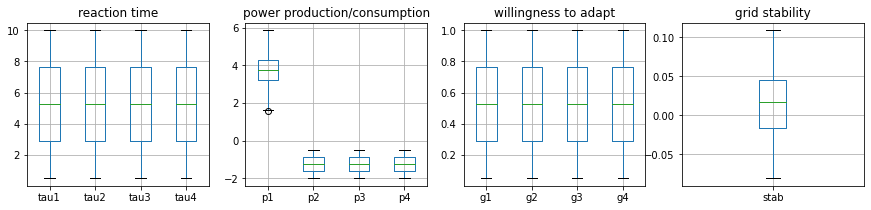

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for axs_ind, feature_group in enumerate(["tau", "p", "g"]):
    smart_grid_orig.boxplot(
        column=[feature_group + str(i + 1) for i in range(4)], 
        ax= axs[axs_ind]
    )
smart_grid_orig.boxplot(column="stab", ax= axs[3])

for axs_ind, title in enumerate(["reaction time", "power production/consumption",
                                 "willingness to adapt", "grid stability"]):
    axs[axs_ind].set(title=title);

In [5]:
print(smart_grid_orig["stabf"].value_counts(normalize=True))  # pretty balanced

unstable    0.638
stable      0.362
Name: stabf, dtype: float64


In [6]:
smart_grid = smart_grid_orig.assign(stabf = lambda x: x.stabf.replace({"unstable": 0, "stable": 1}))

smart_grid.columns = (smart_grid.columns
                      .str.replace("tau", "delay")
                      .str.replace("p", "power")
                      .str.replace("g", "adapt"))

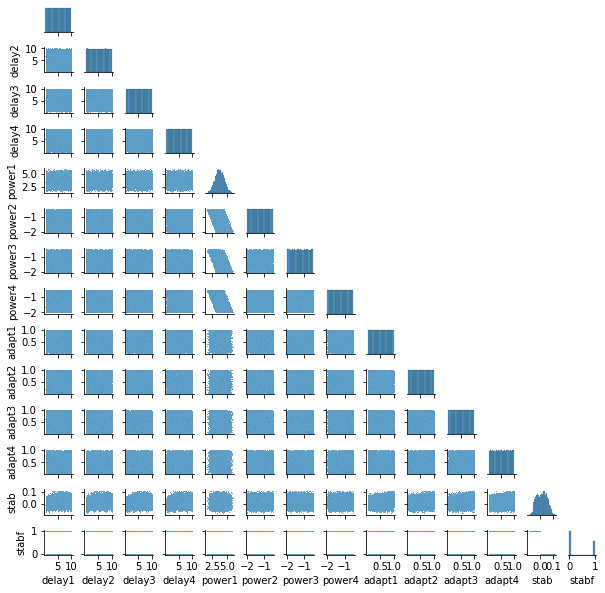

In [7]:
g = sns.PairGrid(smart_grid, diag_sharey=False,
                 corner=True, height=0.6, aspect=1)
g.map_lower(sns.scatterplot, s=1)
g.map_diag(sns.histplot);

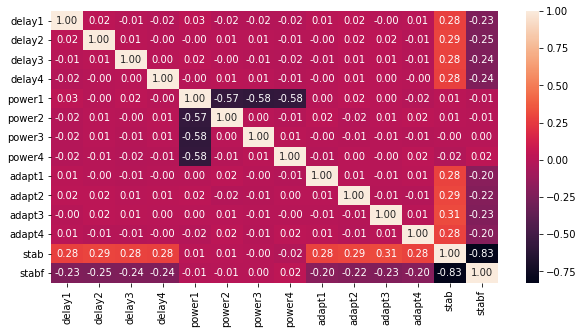

In [8]:
plt.figure(figsize = (10, 5))
sns.heatmap(smart_grid.corr(), fmt=".2f", annot=True);  # default pearson

The correlation between stability (`stab` or `stabf`) and `delay[x]` or `adapt[x]` columns were weak, whereas there was no obvious relationship between `power[x]` columns and stability.

`power1` (power generated) was correlated with the other `power[x]` columns (power consumed), as expected, but there was no obvious correlation within `delay[x]` or `adapt[x]` columns.

In [9]:
# https://www.researchgate.net/post/Multicollinearity_issues_is_a_value_less_than_10_acceptable_for_VIF
feat_cols = smart_grid.drop(["stab", "stabf"], axis=1).columns

(pd.DataFrame({
    "variables": smart_grid[feat_cols].columns,
    "VIF": [variance_inflation_factor(smart_grid[feat_cols].values, ind)
            for ind in range(len(feat_cols))]
})
 .rename({"variables": ""}, axis=1)
 .set_index("")
 .transpose()
)

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,delay1,delay2,delay3,delay4,power1,power2,power3,power4,adapt1,adapt2,adapt3,adapt4
VIF,4.411883,4.373177,4.387577,4.342155,inf,inf,inf,inf,4.358228,4.39541,4.3677,4.321428


Both Pearson correlation and variance inflation factor suggested `power[x]` columns may be collinear, so I should remove the producer `power1` column.

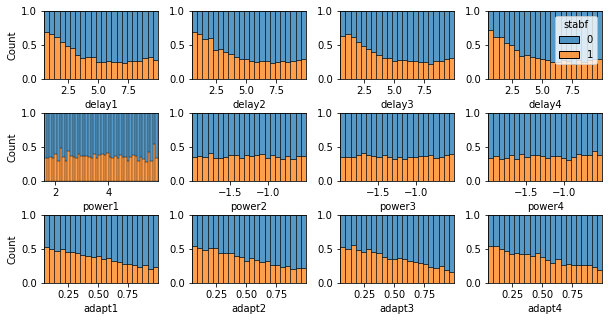

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(10, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

for row_ind, feat_type in enumerate(["delay", "power", "adapt"]):
    for col_ind in range(4):
        show_legend = True if (row_ind == 0) & (col_ind == 3) else False
        sns.histplot(
            smart_grid, x=feat_type + str(col_ind + 1), hue="stabf",
            multiple="fill", legend=show_legend,
            ax=axs[row_ind, col_ind]
        )
        
        if col_ind > 0:
            axs[row_ind, col_ind].set_ylabel("")

Share of unstable events:
- increased with reaction delay (of both producers and consumers) until roughly 5 seconds, after which the share of unstable events was relatively unaffected by further increases in delay times
- increased linearly with willingness to adapt (of both producers and consumers)
- still seemed uncorrelated with amount of power produced or consumed

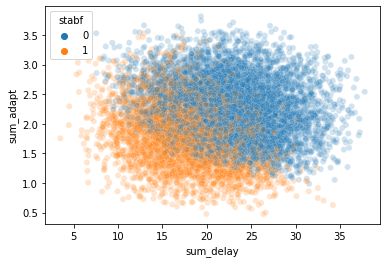

In [11]:
(smart_grid
 .assign(
     sum_delay = lambda x: x["delay1"] + x["delay2"] + x["delay3"] + x["delay4"],
     sum_adapt = lambda x: x["adapt1"] + x["adapt2"] + x["adapt3"] + x["adapt4"]
 )
 .pipe((sns.scatterplot, "data"), 
       x="sum_delay", y="sum_adapt", hue="stabf", alpha=0.2)
);

Together, very high or very low sums of `delay[x]` and `adapt[x]` values should be indicators of (in)stability. Without further processing, these summarised values would highly correlate with existing features, so I'd rather keep the individual features. In contrast, it might be worth removing all `power[x]` columns if they're unhelpful.

Back to [Overview](#overview)

<a id="build-baseline-models"></a>
### Build baseline models

*Fit baseline models (include feature scaling in pipeline to avoid data leakage but allow for easy adjustments when optimising), use feature/permutation importance and coefficients to confirm feature selection, check for overfitting*

I first split the data, holding out 20% as the test set and using stratification to keep a consistent class share for the classification task:

In [12]:
# following conventions, X contains the features and y contains the labels
X = smart_grid.drop(["stab", "stabf"], axis=1)
y = smart_grid[["stab", "stabf"]]

X_train_val_, X_test_, y_train_val, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y["stabf"], random_state=0)

# unsure about how X should be processed at the moment
X_train_val_w_pwr = X_train_val_.drop(["power1"], axis=1)
X_train_val_no_pwr = (X_train_val_
                      .drop(["power1", "power2", "power3", "power4"], axis=1))
# labels for both tasks
clf_y_train_val, clf_y_test = y_train_val["stabf"], y_test["stabf"]
reg_y_train_val, reg_y_test = y_train_val["stab"], y_test["stab"]

assert all(clf_y_train_val.value_counts(normalize=True) == \
    clf_y_test.value_counts(normalize=True)), \
    "inconsistent class share afer split"

To get a better understanding of the data and which models perform well, I fitted a few models using 5-fold cross validation to two versions of the data (with or without the consumer `power[x]` features):

In [13]:
# classifiers
log_reg = LogisticRegression(random_state=1)
rfc = RandomForestClassifier(random_state=1)
knc = KNeighborsClassifier()
lgbc = LGBMClassifier(random_state=1)
svc = SVC()

# regressors
lin_reg = LinearRegression()
rfr = RandomForestRegressor(random_state=1)
knr = KNeighborsRegressor()
lgbr = LGBMRegressor(random_state=1)
svr = SVR()

# cross-validation splitters
skf = StratifiedKFold(random_state=1, shuffle=True)
kf = KFold(random_state=1, shuffle=True)
print("For classifiers:", skf)
print("For regressors:", kf)

For classifiers: StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
For regressors: KFold(n_splits=5, random_state=1, shuffle=True)


In [14]:
def get_baseline_scores(est_names, X_train, y_train_val, cv):
    baseline_scores_list = []
    for est_name in est_names:
        pipe = Pipeline(steps=[("scaler", StandardScaler()),
                               ("estimator", globals()[est_name])])
        
        est_res = cross_validate(pipe,
                                 # https://github.com/dmlc/xgboost/issues/6908,
                                 np.ascontiguousarray(X_train),
                                 y_train_val,
                                 cv=cv, return_train_score=True)
        baseline_scores_list.append(
            pd.DataFrame({"estimator": est_name, 
                          "train_score": est_res.get("train_score"),
                          "val_score": est_res.get("test_score"), 
                          "fit_time_s": est_res.get("fit_time")
                         }))
    baseline_scores_df = (pd.concat(baseline_scores_list)
                          .sort_values("val_score", ascending=False))
    return baseline_scores_df


def fmt_bl_scores(scores_df, caption):
    metric_cols = ["train_score", "val_score", "fit_time_s"]
    final_df = (scores_df
                .pipe(pd.pivot_table, 
                      values=metric_cols, 
                      index="estimator", 
                      aggfunc={columns: np.mean for columns in metric_cols})
                .sort_values("val_score", ascending=False)
                
                # display options
                .style.format("{:.1%}", subset=["train_score", "val_score"])
                .set_table_attributes("style='display:inline'")
                .set_caption(caption)._repr_html_())
    return final_df

blc_w_pwr = get_baseline_scores(["log_reg", "rfc", "knc", "lgbc", "svc"],
                                X_train_val_w_pwr, clf_y_train_val, skf)
blc_no_pwr = get_baseline_scores(["log_reg", "rfc", "knc", "lgbc", "svc"],
                                 X_train_val_no_pwr, clf_y_train_val, skf)

blr_w_pwr = get_baseline_scores(["lin_reg", "rfr", "knr", "lgbr", "svr"],
                                X_train_val_w_pwr, reg_y_train_val, kf)
blr_no_pwr = get_baseline_scores(["lin_reg", "rfr", "knr", "lgbr", "svr"],
                                 X_train_val_no_pwr, reg_y_train_val, kf)
        
display_html(
    fmt_bl_scores(blc_w_pwr, 
                  "Baseline classifier accuracy (with power columns)") +
    "\xa0" * 2 +  # so both still fit in a line on small screens
    fmt_bl_scores(blc_no_pwr, 
                  "Baseline classifier accuracy (no power columns)") +
    "<br/><br/>" +
    fmt_bl_scores(blr_w_pwr,
                  "Baseline regressor R2 (with power columns)") +
    "\xa0" * 2 +
    fmt_bl_scores(blr_no_pwr, 
                  "Baseline regressor R2 (no power columns)"),
    raw=True
)

,fit_time_s,train_score,val_score
estimator,,,
svc,0.766715,97.8%,95.7%
lgbc,0.199482,100.0%,93.9%
rfc,1.709569,100.0%,91.5%
knc,0.011315,91.7%,85.8%
log_reg,0.027013,81.5%,81.5%
,fit_time_s,train_score,val_score
estimator,,,
svc,0.561620,98.0%,96.8%
lgbc,0.168001,100.0%,94.1%


Removing the consumer `power[x]` columns increased accuracy scores for the top four out of five classifiers, and maintained or increased the R<sup>2</sup> score for all regressors. To get a better feel for whether the `power[x]` columns add useful information, I looked at the feature/permutation importance in tree-based models and absolute values of coefficients in L1-penalised linear models for each feature. As examples, I'm showing one type each for classification and regression models:

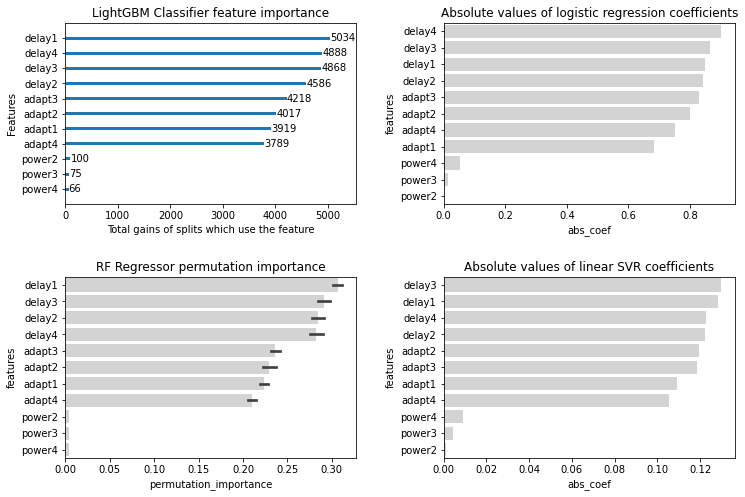

In [15]:
X_train_wp, X_val_wp, clf_y_train_wp, clf_y_val_wp = \
    train_test_split(X_train_val_w_pwr, clf_y_train_val, 
                     test_size = 0.3, random_state=0)
X_train_wp, X_val_wp, reg_y_train_wp, reg_y_val_wp = \
    train_test_split(X_train_val_w_pwr, reg_y_train_val, 
                     test_size = 0.3, random_state=0)

## LightGBM feature importances
lgbc.fit(X_train_wp, clf_y_train_wp)

## RF permutation importances (model agnostic method)
rfr.fit(X_train_wp, reg_y_train_wp)
rfr_pi_res = permutation_importance(rfr, X_train_wp, reg_y_train_wp,
                                   n_repeats=10, random_state=0)
rfr_pi_df = (pd.DataFrame(rfr_pi_res.get("importances"),
                         index=X_train_wp.columns,
                         columns=[i + 1 for i in range(10)])
            .reset_index()
            .pipe(pd.melt,
                  id_vars=["index"], value_vars=[i + 1 for i in range(10)],
                  var_name="rep", value_name="permutation_importance")
            .rename(columns={"index": "features"}))
rfr_pi_order = (rfr_pi_df.groupby("features")
               .mean("permutation_importance")
               .sort_values("permutation_importance", ascending=False).index)

## Logistic Regression/Linear SVC coefficients (L1-based)
ss = StandardScaler()
def plot_abs_coefs(model_inst, model_name, y_train, ax):
    coefs_df = pd.DataFrame(
        {"features": X_train_wp.columns,
         "coefficients": (model_inst
                          .fit(ss.fit_transform(X_train_wp), clf_y_train_wp)
                          .coef_.flatten())}
    ).assign(abs_coef = lambda x: x["coefficients"].map(abs))
    feat_order = (coefs_df
                  .groupby("features").mean("abs_coef")
                  .sort_values("abs_coef", ascending=False).index)
    (sns.barplot(data=coefs_df, x="abs_coef", y="features",
                color="lightgrey", order=feat_order, ax=ax)
     .set(title=f"Absolute values of {model_name} coefficients"))
    
## Plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

plot_importance(lgbc, xlabel="Total gains of splits which use the feature", 
                title="LightGBM Classifier feature importance",
                importance_type="gain", precision=0, grid=False, ax=axs[0, 0])
plot_abs_coefs(model_inst=LogisticRegression(solver="liblinear", penalty="l1"),
               model_name="logistic regression", 
               y_train=clf_y_train_wp, ax=axs[0, 1])

sns.barplot(data=rfr_pi_df, x="permutation_importance", y="features",
            ci="sd", order=rfr_pi_order, color="lightgrey",
            ax=axs[1, 0]).set(title="RF Regressor permutation importance")
plot_abs_coefs(model_inst=LinearSVR(random_state=1, max_iter=2000),
               model_name="linear SVR", y_train=reg_y_train_wp, ax=axs[1, 1]);

As suggested by the data exploration and baseline model performances, reaction delay and willingness to adapt seem to be much more relevant than amount of power consumed for both the classification and regression tasks. To me, this suggests the `power[x]` columns were adding more noise than signal, and should be removed moving forward:

In [16]:
def process_X(X_df):
    final_df = X_df.drop(["power1", "power2", "power3", "power4"], axis=1)
    return final_df

X_train_val = process_X(X_train_val_)
X_test = process_X(X_test_)

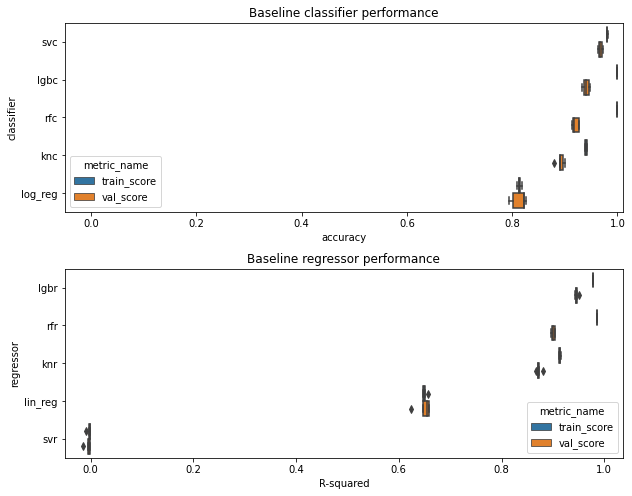

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.3)
for metric_df, ax_pos, estimator, metric in \
    zip([blc_no_pwr, blr_no_pwr], [0, 1],
        ["classifier", "regressor"], ["accuracy", "R-squared"]):
    (metric_df
     .pipe(pd.melt, 
           id_vars="estimator", 
           value_vars=["train_score", "val_score"], 
           var_name="metric_name", value_name="metric_value")
     .pipe((sns.boxplot, "data"), x="metric_value", y="estimator", 
           hue="metric_name", ax=axs[ax_pos])
     .set(title=f"Baseline {estimator} performance",
         xlim=(-0.05, None), xlabel=metric, ylabel=estimator))

Focusing on models that were fitted on the data without power consumption columns, all classifiers scored over 80% on validation accuracy. Support Vector (`svc`), Light Gradient Boosting Machine (LightGBM, `lgbc`) and random forest (RF, `rfc`) models gave the best scores. Validation R<sup>2</sup> were extremely varied across regressors, with LightGBM (`lgbr`), RF (`rfr`) and K-Nearest Neighbour (`knr`) being the best performers.

For both classification and regression, the LightGBM and RF models had close-to-perfect train scores. This could suggest overfitting, but is not uncommon for such ensemble models, since enough trees could have trained on each training case to outweigh those that didn't. Instead of scoring based on the default accuracy for classification and R<sup>2</sup> for regression, I could look at log loss and mean squared error (MSE), for example:

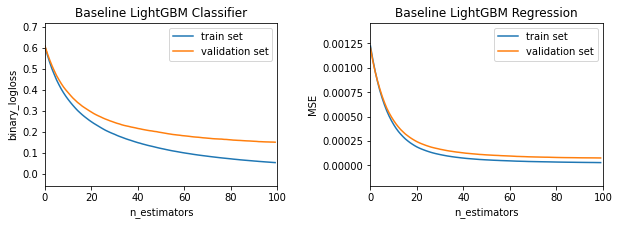

In [18]:
X_train, X_val, clf_y_train, clf_y_val = \
    train_test_split(X_train_val, clf_y_train_val, 
                     test_size = 0.3, random_state=0)
X_train, X_val, reg_y_train, reg_y_val = \
    train_test_split(X_train_val, reg_y_train_val, 
                     test_size = 0.3, random_state=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.4)
lgbc.fit(X_train, clf_y_train, 
        eval_set=[(X_train, clf_y_train), (X_val, clf_y_val)], 
        eval_names=["train set", "validation set"], verbose=0)
lgbr.fit(X_train, reg_y_train, 
        eval_set=[(X_train, reg_y_train), (X_val, reg_y_val)], 
        eval_names=["train set", "validation set"], verbose=0)
plot_metric(lgbc, title="Baseline LightGBM Classifier",
            xlabel="n_estimators", grid=False, ax=axs[0])
plot_metric(lgbr, title="Baseline LightGBM Regression",
            xlabel="n_estimators", ylabel="MSE", grid=False, ax=axs[1]);

For the LightGBM classifier, neither training nor validation log loss had decreased to a stable level. If anything, I think it was probably underfitted, so I can increase the learning rate and/or number of trees. The fit looks much better for the LightGBM regressor, but the validation MSE doesn't start to deviate from the train MSE again, so I think it's still not overfitted.

Another way check the fit on training samples is to look at out-of-bag (OOB) scores in RF models (ie. calculate scores using only trees that didn't train on the particular training samples), for example:

In [19]:
rfc.fit(X_train, clf_y_train)
rfc_oob = RandomForestClassifier(oob_score=True, random_state=0)
rfc_oob.fit(X_train, clf_y_train)

rfr.fit(X_train, reg_y_train)
rfr_oob = RandomForestRegressor(oob_score=True, random_state=0)
rfr_oob.fit(X_train, reg_y_train)

pd.DataFrame({
    "classifier": [rfc.score(X_train, clf_y_train),
                   rfc_oob.oob_score_,
                   rfc.score(X_val, clf_y_val)],
    "regressor": [rfr.score(X_train, reg_y_train),
                  rfr_oob.oob_score_,
                  rfr.score(X_val, reg_y_val)],
}, index=["training set score", "training set OOB score",
          "validation set score"]
).style.format("{:.3f}").set_caption("Baseline RF performance")

,classifier,regressor
training set score,1.000,0.985
training set OOB score,0.910,0.895
validation set score,0.929,0.898


Unlike the default training scores, the OOB training scores were slightly lower than the validation scores for both tasks, so I don't think the baseline RF models were overfitted either.

Back to [Overview](#overview)

<a id="optimise-models"></a>
### Optimise models
*Hyperparameter tuning with randomised and grid searches*

To search for optimised hyperparameters and feature transformers, I used exhaustive grid searches when the search space is small, otherwise randomly searched 60 conditions, which should give me [a close approximate](https://www.oreilly.com/library/view/evaluating-machine-learning/9781492048756/ch04.html) if at least 5% of the total conditions in the search space are close-to-optimal.

The feature transformations I explored were: standardising the feature so it has a mean of 0 and standard deviation of 1 (`StandardScaler`), rescaling the feature using outlier-insensitive statistics (`RobustScaler`) or [collapsing any outliers](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html?highlight=scalers#quantiletransformer-uniform-output) (`QuantileTransformer`). For context, I also added `FunctionTransformer`, which allows me to exclude the transformation step.

In [20]:
def gen_search_eval(estimator_name: str, search_params,
                    pred_task:str, search_mode: str):

    cv = skf if pred_task == "clf" else kf
    y_train_val = clf_y_train_val if pred_task == "clf" else reg_y_train_val
    
    pipeline_steps = Pipeline(
        steps=[("transformer", StandardScaler()),
                ("estimator", globals()[estimator_name])]
    )
    
    common_args = dict(estimator=pipeline_steps, n_jobs=-1, 
                       cv=cv, verbose=1,
                       return_train_score=True,  # to check for overfitting
                       error_score="raise")  # if error during fitting
    random_cv = RandomizedSearchCV(param_distributions=search_params, 
                                   n_iter=60, random_state=1, **common_args)
    grid_cv = GridSearchCV(param_grid=search_params, **common_args)
    search_cv = grid_cv if search_mode == "grid" else random_cv

    search_cv.fit(X_train_val, y_train_val)
    return search_cv


def fmt_search_res(search_res):
    summary_df = pd.DataFrame(
        {key: search_res.cv_results_.get(key) 
         for key in ["params", "rank_test_score", 
                     "mean_fit_time", "mean_score_time",
                     "mean_train_score", "mean_test_score",
                     "std_train_score", "std_test_score"]}
    )
    
    final_df = (pd.DataFrame(summary_df["params"].tolist())  # expand params
                .reset_index()
                .merge(summary_df.reset_index(drop=True).reset_index())
                .drop(["index", "params"], axis=1)
                .sort_values(["mean_test_score", "mean_fit_time"], 
                             ascending=[False, True]))
    return final_df


# feature transformations important for distance-based algo eg. SVM, KNN
transformers = [StandardScaler(),  # very sensitive to outliers
                RobustScaler(),  # not affected by a few extreme outliers
                FunctionTransformer(lambda x: x),  # do nothing
                QuantileTransformer()]  # collapses outliers

**Support Vector Machine**

SVM generates hyperplanes that separate data points from each class for classification problems, or minimise distance of all points from the plane for regression problems. Some of the most important hyperparameters are probably the kernel that is used to transform the data, and a few parameters that adjust the regularisation.

In [21]:
svm_params = [{"estimator__kernel": ["rbf", "sigmoid"],  # default rbf
               # gamma reshapes decision boundary (high overfits)
               "estimator__gamma": ["auto", "scale"]},  # default scale
              {"estimator__kernel": ["linear"]}]  # gamma not affect linear

for param_dict in [0, 1]:
    svm_params[param_dict].update({"transformer": transformers,
                                   "estimator__C": np.logspace(-2, 2, 5)})

svc_raw_clf_res = gen_search_eval("svc", svm_params, "clf", "random")
print(f"\nBest classifier pipeline: {svc_raw_clf_res.best_estimator_}")

svc_clf_res = fmt_search_res(svc_raw_clf_res)
svc_clf_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer', RobustScaler()),
                ('estimator', SVC(C=100.0, gamma='auto'))])


,transformer,estimator__kernel,estimator__C,estimator__gamma,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
9,RobustScaler(),rbf,100.0,auto,1,0.797773,0.110361,0.990500,0.973500,0.000729,0.003368
37,QuantileTransformer(),rbf,10.0,scale,2,0.631020,0.146469,0.994281,0.970375,0.000682,0.003414
36,StandardScaler(),rbf,10.0,auto,3,0.604554,0.146036,0.994594,0.970250,0.000645,0.003077


In [22]:
svr_raw_reg_res = gen_search_eval("svr", svm_params, "reg", "random")
print(f"\nBest regressor pipeline: {svr_raw_reg_res.best_estimator_}")

svr_reg_res = fmt_search_res(svr_raw_reg_res)
svr_reg_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best regressor pipeline: Pipeline(steps=[('transformer', StandardScaler()),
                ('estimator', SVR(C=0.01, kernel='linear'))])


,transformer,estimator__kernel,estimator__C,estimator__gamma,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
26,FunctionTransformer(func=<function <lambda> at...,linear,10.00,NaN,1,0.006279,0.003036,-0.003062,-0.004554,0.003137,0.004893
40,FunctionTransformer(func=<function <lambda> at...,linear,0.10,NaN,1,0.006316,0.003244,-0.003062,-0.004554,0.003137,0.004893
20,FunctionTransformer(func=<function <lambda> at...,rbf,0.01,auto,1,0.006872,0.003418,-0.003062,-0.004554,0.003137,0.004893


**Light Gradient Boosting Machine**

Gradient boosting models iteratively build weak prediction models, minimising loss at each stage. Of the gradient boosting models available, I picked LightGBM, since it tends to be [much faster than XGBoost](https://github.com/Microsoft/LightGBM/blob/master/docs/Experiments.rst#comparison-experiment) as well as [CatBoost](https://publications.waset.org/10009954/comparison-between-xgboost-lightgbm-and-catboost-using-a-home-credit-datasethttps://publications.waset.org/10009954/comparison-between-xgboost-lightgbm-and-catboost-using-a-home-credit-dataset), while giving similar results. LightGBM has an [overwhelming number of adjustable parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html), some that adjust the ensemble model itself and others that put constraints on the individual trees.

In [23]:
lgb_params = {
    "transformer": transformers,
    # generally, slower learning rates need more trees
    "estimator__n_estimators": [50, 100, 250, 500],  # default 100
    "estimator__learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],  # default 0.1
    "estimator__boosting_type": ["gbdt", "dart"],  # default gbdt
    # restrict tree growth and adjust regularisation to prevent overfitting
    "estimator__max_depth": [25, 50, -1],  # default -1 (no limit)
    "estimator__min_child_samples": [20, 30, 40],  # default 20
    "estimator__reg_alpha": np.logspace(-2, 2, 5),  # lambda_l1; default 0
    "estimator__reg_lambda": np.logspace(-2, 2, 5)  # lambda_l2; default 0
}

lgbc_raw_clf_res = gen_search_eval("lgbc", lgb_params, "clf", "random")
print(f"\nBest classifier pipeline: {lgbc_raw_clf_res.best_estimator_}")

lgbc_clf_res = fmt_search_res(lgbc_raw_clf_res)
lgbc_clf_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer',
                 FunctionTransformer(func=<function <lambda> at 0x7f4ed5c4ecb0>)),
                ('estimator',
                 LGBMClassifier(learning_rate=0.3, min_child_samples=30,
                                n_estimators=500, random_state=1, reg_alpha=0.1,
                                reg_lambda=10.0))])


,transformer,estimator__reg_lambda,estimator__reg_alpha,estimator__n_estimators,estimator__min_child_samples,estimator__max_depth,estimator__learning_rate,estimator__boosting_type,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
53,FunctionTransformer(func=<function <lambda> at...,10.0,0.1,500,30,-1,0.3,gbdt,1,1.745025,0.110691,1.0,0.95550,0.0,0.006317
34,StandardScaler(),10.0,0.1,250,20,25,0.2,gbdt,2,0.962449,0.042624,1.0,0.95375,0.0,0.007082
38,StandardScaler(),10.0,1.0,500,40,50,0.1,gbdt,2,1.773483,0.112237,1.0,0.95375,0.0,0.007192


In [24]:
lgbr_raw_reg_res = gen_search_eval("lgbr", lgb_params, "reg", "random")
print(f"\nBest regressor pipeline: {lgbr_raw_reg_res.best_estimator_}")

lgbr_reg_res = fmt_search_res(lgbr_raw_reg_res)
lgbr_reg_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best regressor pipeline: Pipeline(steps=[('transformer', QuantileTransformer()),
                ('estimator',
                 LGBMRegressor(boosting_type='dart', learning_rate=0.3,
                               max_depth=25, min_child_samples=30,
                               n_estimators=250, random_state=1, reg_alpha=0.01,
                               reg_lambda=0.01))])


,transformer,estimator__reg_lambda,estimator__reg_alpha,estimator__n_estimators,estimator__min_child_samples,estimator__max_depth,estimator__learning_rate,estimator__boosting_type,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
0,QuantileTransformer(),0.01,0.01,250,30,25,0.3,dart,1,3.242590,0.045967,0.989932,0.960280,0.000113,0.002185
4,RobustScaler(),10.00,0.01,250,30,25,0.1,gbdt,2,0.869199,0.044272,0.988652,0.956985,0.000244,0.002324
50,StandardScaler(),10.00,0.10,250,20,-1,0.1,gbdt,3,0.879209,0.046616,0.983781,0.955541,0.000268,0.003311


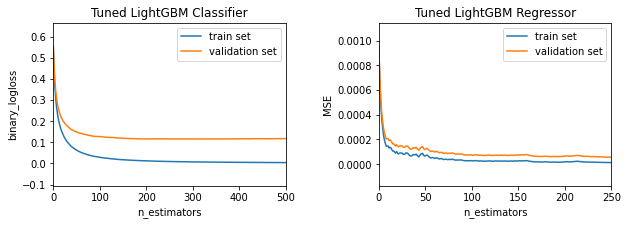

In [25]:
# take just estimator parts since plot_metric doesn't work with pipelines
tuned_lgbc = lgbc_raw_clf_res.best_estimator_[1]
tuned_lgbr = lgbr_raw_reg_res.best_estimator_[1]
qt = QuantileTransformer()

tuned_lgbc.fit(X_train, clf_y_train, 
           eval_set=[(X_train, clf_y_train), 
                     (X_val, clf_y_val)], 
           eval_names=["train set", "validation set"],
           verbose=0)
tuned_lgbr.fit(qt.fit_transform(X_train), reg_y_train, 
           eval_set=[(qt.fit_transform(X_train), reg_y_train), 
                     (qt.transform(X_val), reg_y_val)], 
           eval_names=["train set", "validation set"],
           verbose=0)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.4)
plot_metric(tuned_lgbc, title="Tuned LightGBM Classifier",
            xlabel="n_estimators", grid=False, ax=axs[0])
plot_metric(tuned_lgbr, title="Tuned LightGBM Regressor",
            xlabel="n_estimators", ylabel="MSE", grid=False, ax=axs[1]);

With the tuned parameters, both training and validation loss decrease to a plateau for the best tuned classifier and regressor. The classifier fit improved from the baseline model; the regressor fit seems similar, but importantly, not overfitted.

**Random Forest**

Random forest models build decision trees from random subsets of samples and features, and also have many hyperparameters to tune. Of course the impact of each parameter may vary depending on the data set. For example, with only eight features in our data set, setting `max_features` to "auto", "sqrt" or "log2" should have no significant impact on performance - in all cases, three features should be considered at each split (though `max_features` could still be set to a specific number instead).

In [26]:
rf_params = {
    "transformer": transformers,
    "estimator__n_estimators": [50, 100, 250, 500],  # default 100
    "estimator__max_depth": [15, 50, None],
    "estimator__min_samples_split": [2, 5, 10],  # default 2
    "estimator__min_samples_leaf": [1, 2, 5]  # default 1
}

rfc_raw_clf_res = gen_search_eval("rfc", rf_params, "clf", "random")
print(f"\nBest classifier pipeline: {rfc_raw_clf_res.best_estimator_}")

rfc_clf_res = fmt_search_res(rfc_raw_clf_res)
rfc_clf_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer', RobustScaler()),
                ('estimator',
                 RandomForestClassifier(max_depth=50, min_samples_split=5,
                                        n_estimators=500, random_state=1))])


,transformer,estimator__n_estimators,estimator__min_samples_split,estimator__min_samples_leaf,estimator__max_depth,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
28,RobustScaler(),500,5,1,50.0,1,8.259277,0.239167,1.0,0.924125,0.0,0.004412
43,QuantileTransformer(),500,2,1,50.0,2,8.343555,0.260318,1.0,0.923875,0.0,0.006090
37,RobustScaler(),500,5,1,15.0,3,8.404518,0.260805,1.0,0.923250,0.0,0.004991


In [27]:
rfr_raw_reg_res = gen_search_eval("rfr", rf_params, "reg", "random")
print(f"\nBest regressor pipeline: {rfr_raw_reg_res.best_estimator_}")

rfr_reg_res = fmt_search_res(rfr_raw_reg_res)
rfr_reg_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best regressor pipeline: Pipeline(steps=[('transformer', QuantileTransformer()),
                ('estimator',
                 RandomForestRegressor(max_depth=50, n_estimators=500,
                                       random_state=1))])


,transformer,estimator__n_estimators,estimator__min_samples_split,estimator__min_samples_leaf,estimator__max_depth,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
43,QuantileTransformer(),500,2,1,50.0,1,29.277818,0.329768,0.986727,0.901952,0.000128,0.003712
27,StandardScaler(),500,2,2,50.0,2,25.488514,0.246194,0.981449,0.901852,0.000190,0.003984
56,FunctionTransformer(func=<function <lambda> at...,500,2,2,15.0,3,24.800492,0.228808,0.981101,0.901618,0.000209,0.003985


In [28]:
tuned_rfc = rfc_raw_clf_res.best_estimator_[1]
tuned_rfc_oob = rfc_raw_clf_res.best_estimator_[1]
tuned_rfc_oob.set_params(oob_score=True)
tuned_rfr = rfr_raw_reg_res.best_estimator_[1]
tuned_rfr_oob = rfr_raw_reg_res.best_estimator_[1]
tuned_rfr_oob.set_params(oob_score=True)

rs = RobustScaler()
tuned_rfc.fit(rs.fit_transform(X_train), clf_y_train)
tuned_rfc_oob.fit(rs.fit_transform(X_train), clf_y_train)
qt = QuantileTransformer()
tuned_rfr.fit(qt.fit_transform(X_train), reg_y_train)
tuned_rfr_oob.fit(qt.fit_transform(X_train), reg_y_train)

pd.DataFrame({
    "classifier": [tuned_rfc.score(rs.transform(X_train), clf_y_train),
                   tuned_rfc_oob.oob_score_,
                   tuned_rfc.score(rs.transform(X_val), clf_y_val)],
    "regressor": [tuned_rfr.score(qt.transform(X_train), reg_y_train),
                  tuned_rfr_oob.oob_score_,
                  tuned_rfr.score(qt.transform(X_val), reg_y_val)],
}, index=["training set score", "training set OOB score",
          "validation set score"]
).style.format("{:.3f}").set_caption("Tuned RF performance")

,classifier,regressor
training set score,1.000,0.986
training set OOB score,0.921,0.900
validation set score,0.931,0.899


Neither tuned RF classifier nor regressor seem overfitted.

**KNN**

k-nearest neighbours makes predictions based on values of the nearest neighbours. For classification, this is summarised by a simple majority vote, whereas averaging is used for regression. This of course means hyperparameters related to the number of neighbours, how distances are calculated and how much weight is put on each neighbour's value affect the performance.

In [29]:
# typical k to start with (eg. https://stackoverflow.com/a/11569262):
print("Typical `k` to start with (square root of number of samples): ",
      np.sqrt(X_train_val.shape[0]))

knn_params = {
    "transformer": transformers,
    "estimator__n_neighbors": [5, 15, 45, 90],  # default 5
    # distance function, default minkowski
    "estimator__metric": ["minkowski", "euclidean", "manhattan"],
    "estimator__weights": ["uniform", "distance"],  # default uniform
    "estimator__algorithm" : ["auto", "ball_tree", "kd_tree"]  # default auto
}

knc_raw_clf_res = gen_search_eval("knc", knn_params, "clf", "random")
print(f"\nBest classifier pipeline: {knc_raw_clf_res.best_estimator_}")

knc_clf_res = fmt_search_res(knc_raw_clf_res)
knc_clf_res.head(3)

Typical `k` to start with (square root of number of samples):  89.44271909999159
Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best classifier pipeline: Pipeline(steps=[('transformer', QuantileTransformer()),
                ('estimator',
                 KNeighborsClassifier(algorithm='ball_tree', metric='manhattan',
                                      n_neighbors=15, weights='distance'))])


,transformer,estimator__weights,estimator__n_neighbors,estimator__metric,estimator__algorithm,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
33,QuantileTransformer(),distance,15,manhattan,kd_tree,1,0.042116,0.261872,1.0,0.904250,0.0,0.010734
11,QuantileTransformer(),distance,15,manhattan,ball_tree,1,0.046632,0.275089,1.0,0.904250,0.0,0.010734
34,RobustScaler(),distance,15,manhattan,ball_tree,3,0.022567,0.238528,1.0,0.903875,0.0,0.010668


In [30]:
knr_raw_reg_res = gen_search_eval("knr", knn_params, "reg", "random")
print(f"\nBest regressor pipeline: {knr_raw_reg_res.best_estimator_}")

knr_reg_res = fmt_search_res(knr_raw_reg_res)
knr_reg_res.head(3)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best regressor pipeline: Pipeline(steps=[('transformer', QuantileTransformer()),
                ('estimator',
                 KNeighborsRegressor(algorithm='ball_tree', metric='manhattan',
                                     n_neighbors=15, weights='distance'))])


,transformer,estimator__weights,estimator__n_neighbors,estimator__metric,estimator__algorithm,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
11,QuantileTransformer(),distance,15,manhattan,ball_tree,1,0.040138,0.238723,1.0,0.881570,0.0,0.003647
33,QuantileTransformer(),distance,15,manhattan,kd_tree,1,0.040262,0.258324,1.0,0.881570,0.0,0.003647
34,RobustScaler(),distance,15,manhattan,ball_tree,3,0.021219,0.242946,1.0,0.881429,0.0,0.003281


**Logistic/Linear Regression**

Linear regression linearly combines the input features. In logistic regression, the results are then transformed into probabilities. I explored parameters controlling regularisation type and strength, as well as the algorithm used to find the optimal coefficients.

In [31]:
log_reg_params = [
    # compatible with both l1 (lasso) and l2 (ridge)
    {"estimator__solver": ["saga", "liblinear"],
     "estimator__penalty": ["l1", "l2"]},
    {"estimator__solver": ["lbfgs", "newton-cg", "sag"],  # default lbfgs
     "estimator__penalty": ["l2"]}]
    
for param_dict in [0, 1]:
    log_reg_params[param_dict].update({"transformer": transformers,
                                       # inverse of lambda, default 1
                                      "estimator__C": np.logspace(-2, 2, 5)})

log_reg_raw_clf_res = gen_search_eval("log_reg", log_reg_params, "clf", "grid")
print(f"\nBest performing pipeline: {log_reg_raw_clf_res.best_estimator_}")

log_reg_clf_res = fmt_search_res(log_reg_raw_clf_res)
log_reg_clf_res.head(3)

Fitting 5 folds for each of 140 candidates, totalling 700 fits

Best performing pipeline: Pipeline(steps=[('transformer', RobustScaler()),
                ('estimator',
                 LogisticRegression(C=0.01, random_state=1, solver='saga'))])


,estimator__C,estimator__penalty,estimator__solver,transformer,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
81,0.01,l2,lbfgs,RobustScaler(),1,0.024826,0.004159,0.813875,0.815,0.001995,0.009569
85,0.01,l2,newton-cg,RobustScaler(),1,0.040001,0.003654,0.813875,0.815,0.001995,0.009569
89,0.01,l2,sag,RobustScaler(),1,0.045156,0.003622,0.813875,0.815,0.001995,0.009569


In [32]:
lin_reg_params = [
    {"estimator": [LinearRegression()]},
    {"estimator": [Lasso(random_state=1)],
     "estimator__alpha": np.logspace(-2, 2, 5)},
    {"estimator": [Ridge(random_state=1)],
     "estimator__alpha": np.logspace(-2, 2, 5),
     "estimator__solver": ["auto", "svd", "sparse_cg", "lsqr", "sag"]} # default auto
    ]
    
lin_reg_raw_reg_res = gen_search_eval("lin_reg", lin_reg_params, "reg", "grid")
print(f"\nBest performing pipeline: {lin_reg_raw_reg_res.best_estimator_}")

lin_reg_reg_res = fmt_search_res(lin_reg_raw_reg_res)
lin_reg_reg_res.head(3)

Fitting 5 folds for each of 31 candidates, totalling 155 fits

Best performing pipeline: Pipeline(steps=[('transformer', StandardScaler()),
                ('estimator',
                 Ridge(alpha=10.0, random_state=1, solver='sparse_cg'))])


,estimator,estimator__alpha,estimator__solver,rank_test_score,mean_fit_time,mean_score_time,mean_train_score,mean_test_score,std_train_score,std_test_score
23,"Ridge(alpha=10.0, random_state=1, solver='spar...",10.0,sparse_cg,1,0.008950,0.002891,0.650059,0.648733,0.003213,0.012781
18,"Ridge(alpha=10.0, random_state=1, solver='spar...",1.0,sparse_cg,2,0.009543,0.003260,0.650060,0.648732,0.003213,0.012782
13,"Ridge(alpha=10.0, random_state=1, solver='spar...",0.1,sparse_cg,3,0.008778,0.002838,0.650061,0.648732,0.003213,0.012782


<a id="hyperparameter-tuning-summary"></a>
**Optimisation summary**

In [33]:
def get_tuned_score(est_name:str, task:str):
    score = globals()[f"{est_name}_raw_{task}_res"].best_score_
    return score

summary_df_display_text = ""

for bl_df, mode in zip([blc_no_pwr, blr_no_pwr], ["clf", "reg"]):
    caption = "classifier summary" if mode == "clf" else "regressor summary"
    html_text = (
        bl_df
        .pipe(pd.pivot_table,
              values="val_score",
              index="estimator",
              aggfunc=np.mean)
        .rename(columns={"val_score": "baseline"})
        .reset_index()
        .sort_values("baseline", ascending=False)
        .assign(tuned = lambda x: x["estimator"].apply(get_tuned_score, task=mode),
                diff = lambda x: x["tuned"] - x["baseline"])
        
        # display options
        .style.format("{:.1%}", subset = ["baseline", "tuned", "diff"])
        .set_table_attributes("style='display:inline'")
        .set_caption(caption)._repr_html_()
    )
    summary_df_display_text = summary_df_display_text + html_text + "\xa0" * 2
    
display_html(summary_df_display_text, raw=True)

,estimator,baseline,tuned,diff
4,svc,96.8%,97.3%,0.6%
1,lgbc,94.1%,95.5%,1.5%
3,rfc,92.0%,92.4%,0.4%
0,knc,89.2%,90.4%,1.2%
2,log_reg,81.4%,81.5%,0.1%
,estimator,baseline,tuned,diff
1,lgbr,94.6%,96.0%,1.4%
3,rfr,90.0%,90.2%,0.2%
0,knr,87.3%,88.2%,0.9%
2,lin_reg,64.9%,64.9%,0.0%


Overall, optimisation maintained or slightly improved accuracy in all classifiers (by 0.1 - 1.5%) and R<sup>2</sup> in all regressors (by 0.0 - 1.4%), with the best performances coming from the SVM classifier and LightGBM regressor.

Back to [Overview](#overview)

<a id="test-final-model"></a>
### Test final model

SVM classifier test score:  0.9825 

              precision    recall  f1-score   support

    Unstable       0.99      0.99      0.99      1276
      Stable       0.98      0.98      0.98       724

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



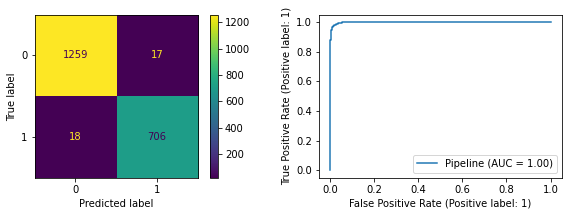

In [34]:
best_clf = svc_raw_clf_res.best_estimator_
best_clf.fit(X_train_val, clf_y_train_val)
print("SVM classifier test score: ", best_clf.score(X_test, clf_y_test), "\n")

print(classification_report(
    y_true=clf_y_test, y_pred=best_clf.predict(X_test),
    labels=[0, 1], target_names=["Unstable", "Stable"]
))

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.3)
plot_confusion_matrix(best_clf, X_test, clf_y_test, ax=axs[0])
plot_roc_curve(best_clf, X_test, clf_y_test, ax=axs[1]);

In [35]:
best_reg = lgbr_raw_reg_res.best_estimator_
best_reg.fit(X_train_val, reg_y_train_val)
print("LightGBM regressor test score: ", best_reg.score(X_test, reg_y_test))

LightGBM regressor test score:  0.9592890303261966


Testing the final classifier on the held out test data scored 98.3% accuracy. Precision, recall and the resulting F1 scores are high in both classes, and the ROC curve looks great. Of course a score this high is extremely rare when working with real data, and suggests there isn't a lot of noise in this simulated data set. Still, [in this publication](https://link.springer.com/article/10.1007/s42979-021-00463-5/tables/3), a deep learning model showed similar performance (97.5% accuracy, 98.7% precision, 98.2% F1-score) on the same data.

The final regressor also performed well, scoring 95.9% R<sup>2</sup> on held out test data.

I then pickled both models:

In [36]:
pickle.dump(best_clf, open("grid_clf.pkl", "wb"))
pickle.dump(best_reg, open("grid_reg.pkl", "wb"))

so that I could easily use them in [a simple app](https://share.streamlit.io/sowla/grid_stability_app/main/grid_stability.py) that can be used to see how adjusting model inputs affect the resulting predictions:

<img src="https://raw.githubusercontent.com/sowla/grid_stability_app/main/img/app.png" alt="streamlit app screenshot" width="70%"/>

The source code, as well as the associated tests and github actions, live [here](https://github.com/sowla/grid_stability_app).

Back to [Overview](#overview)

<a id="interesting-links"></a>
### Interesting links

I thought I'd share a few links/facts I found while doing this project in case they're interesting to anyone else :)

- In Germany, commercial electricity producers and consumers have to give [quarter-hourly forecasts](https://www.amprion.net/Energy-Market/Balancing-Groups/Balancing-Group-Price/Important-Information.html) of the amount of electricity they'll produce/consume. You can see current data [here](https://www.smard.de/home/marktdaten?marketDataAttributes=%7B%22resolution%22:%22hour%22,%22region%22:%22DE%22,%22moduleIds%22:%5B1000100,1000101,1000102,1000103,1000104,1000108,1000109,1000110,1000111,1000112,1000113,1000121,5000410,1001226,1001228,1001227,1001223,1001224,1001225,1004066,1004067,1004068,1004069,1004071,1004070,2000122,6000411%5D,%22selectedCategory%22:null,%22activeChart%22:true,%22style%22:%22color%22%7D) (for periods I've checked, predictions for power consumption is a lot more accurate than for power generation, which makes sense).
- Transmission system operators (TSOs) have to constantly keep track of and react to changes within [their own grids as well as their neighbours'](https://www.entsoe.eu/regions/). So much coordination has to go on that they form "[Regional Security Coordinator](https://www.entsoe.eu/major-projects/rscis/#why-do-we-need-to-strengthen-regional-coordination-now)" (RSC) companies together.
- "Prosumers", individuals and businesses that act as consumers *and* producers, can [contribute to the energy system](https://smarten.eu/wp-content/uploads/2020/05/Smart_Energy_Prosumers_2020.pdf) in many ways.